_version log: Anti-chirping has affected the angle calculation (using delay). Is it still correct?_

In [1]:
import numpy as np
from matplotlib import patches, pyplot as plt
from PIL import Image
import pandas as pd
import os, re
from scipy import interpolate, signal
from scipy.optimize import curve_fit
from scipy.ndimage import median_filter
plt.rcParams.update({'font.size':14})

pixel_pitch = 9.9 #um
c = 299_792_458
source = "ir"
run = "12"
ROI = [[0,491],[150,455]] #region of interest in rows, columns. [[0,491],[0,655]]
background_correction_method = True #True for subtracting background. False for dividing by background. Used by process_fringes
anti_chirping = True #True for applying Elin's anti-chirping code.
angle_calculation_method = "delay" # "manual" for a known angle (ie. measured with ruler), "wavelength" for calibration with a known wavelength or "delay" for calulation using a temporal change on the delay line.
angle_between_beams = 0.363 #degrees. Used if angle_calculation_method == "manual"
delay_line_delta = 2 #um. Distance traveled by delay line between each reading. Used if angle_calculation_method == "delay"
calibration_wavelength = 0.8 #um. Used if angle_calculation_method == "wavelength"

In [2]:
#################FUNCTIONS##################

#Elin's anti-chirping function
def regularspacing(intensity): #calibration intensities
    num_intensities = len(intensity)
    intensitysmooth = median_filter(intensity, 2) #reduces noise and dead pixels
    intensity_index = np.arange(1, num_intensities + 1) #create indexes for intensity. Note that Matlab indexing starts on 1 insted of 0
    fringe_locs, _ = signal.find_peaks(intensitysmooth) #locations of our fringes.
    fringe_locs += 1 #+1 because Matlab uses 1 based indexing
    num_fringes = len(fringe_locs) #number of fringes

    liniar_locs = np.linspace(fringe_locs[0], fringe_locs[-1], num_fringes) #liniarly spaced version of the fringe locations
    p = np.polynomial.polynomial.Polynomial.fit(liniar_locs, fringe_locs, 3) #nppoly does some crazy eigenvector stuff. Use p.convert().coef to get the acual coeffients. Gives a different result from matlab.
    liniar_index = p(intensity_index) #liniarise the indexes
    liniar_intensity = np.interp(intensity_index, liniar_index, intensity) #map the indexes to the interferogram using liniar interpolation where nessisary.
    norm_liniar_intensity = (liniar_intensity / np.max(liniar_intensity)) * -1 + 1 #normalise and invert new liniar interferogram. (why invert???)

    p = np.array([list(p)]*num_intensities)
    p[:,3] -= intensity_index
    roots = [np.polynomial.polynomial.polyroots(polynomial)[2].real for polynomial in p] #find the x intercept of the linierising polynomial. rnreal = 0 for no chirping. Somehow the last solution is never complex?
    return liniar_intensity, intensity_index, norm_liniar_intensity, roots # unchirped intensities ,calibration (1-based) indexes, normalised unchirped intensities, corrected (1-based) indexes

def import_standard_tif(colour, number):
    im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
    fringes = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BA'+number+'.tif')
    beamA = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BB'+number+'.tif')
    beamB = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_bg'+number+'.tif')
    background = np.array(im, dtype= np.float32)
    return fringes, beamA, beamB, background

def find_angle_files(colour, number):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        check = re.findall(colour+'_fringes'+number+'_[0-9]+.tif' , file_name)
        if len(check) != 0:
            new_file_names = new_file_names + [file_name]

            file_number = re.findall('[0-9]+' , file_name)
            new_file_numbers = new_file_numbers + [int(file_number[-1]) -1] #the number that we are looking for is always the last number in the file name
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_angle_arrays(file_names):
    im = Image.open('data\\'+file_names[0]) #for the first interferogram
    angles = np.array(im, dtype= np.float32)
    for file_name in file_names[1:]: #for every other interferogram
        im = Image.open('data\\'+file_name)
        Array = np.array(im, dtype= np.float32)
        angles = np.dstack([angles,Array])
    return angles

def process_fringes(fringes, beamA, beamB, background):
    try:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
    except IndexError:
        nofringes = beamA +beamB -background #ignore the error
    if background_correction_method: #toggle which meathod you want to use. IDK which one is better.
        beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
    else:
        beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors and exaggerates the noise.
        beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                                posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                                neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                                nan= 0) #occors for 0/0
        beamPost -= np.mean(beamPost)
    return beamPost, nofringes

def apply_cross_corrlations(angle_averages, referenace_signal):
        cross_corr = signal.correlate(referenace_signal, angle_averages[:,0], mode='same') #use average_signal as a referance to find the displacements.
        lags = signal.correlation_lags(len(referenace_signal), len(angle_averages[:,0]), mode="same")
        displacements = lags[np.argmax(cross_corr)] #*pixel_pitch #convert from indexes to um.

        for n in np.arange(1,angle_averages.shape[1]): #for every other interferogram
                cross_corr = signal.correlate(angle_averages[:,n], referenace_signal, mode='same') #use average_signal as a referance to find the displacements.
                lags = np.arange(0, len(referenace_signal), 1)
                displacement = lags[np.argmax(cross_corr)] #*pixel_pitch #convert from indexes to um.
                displacements = np.hstack([displacements,displacement])

        return displacements

def line(x,m,k):
    return m*x+k

def Coeffients2Amplitudes(FT, freqs):
        samples = len(FT)
        num_of_freqs = len(FT)//2 +1
        amplitude = np.zeros(num_of_freqs)
        amplitude[0] = np.abs(FT[0])
        if (samples//2 == samples/2): #if even
                amplitude[-1] = np.abs(FT[num_of_freqs-1])
                amplitude[1:-2] = (np.abs( FT[1:num_of_freqs-2] ) +
                                np.abs( FT[:num_of_freqs:-1] ))

                wavelengths = 1/freqs[:num_of_freqs]
                freqs = freqs[:num_of_freqs]
        else: #if odd
                amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))
                wavelengths = 1/freqs[:num_of_freqs]
                freqs = freqs[:num_of_freqs]
        return amplitude, wavelengths, freqs

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

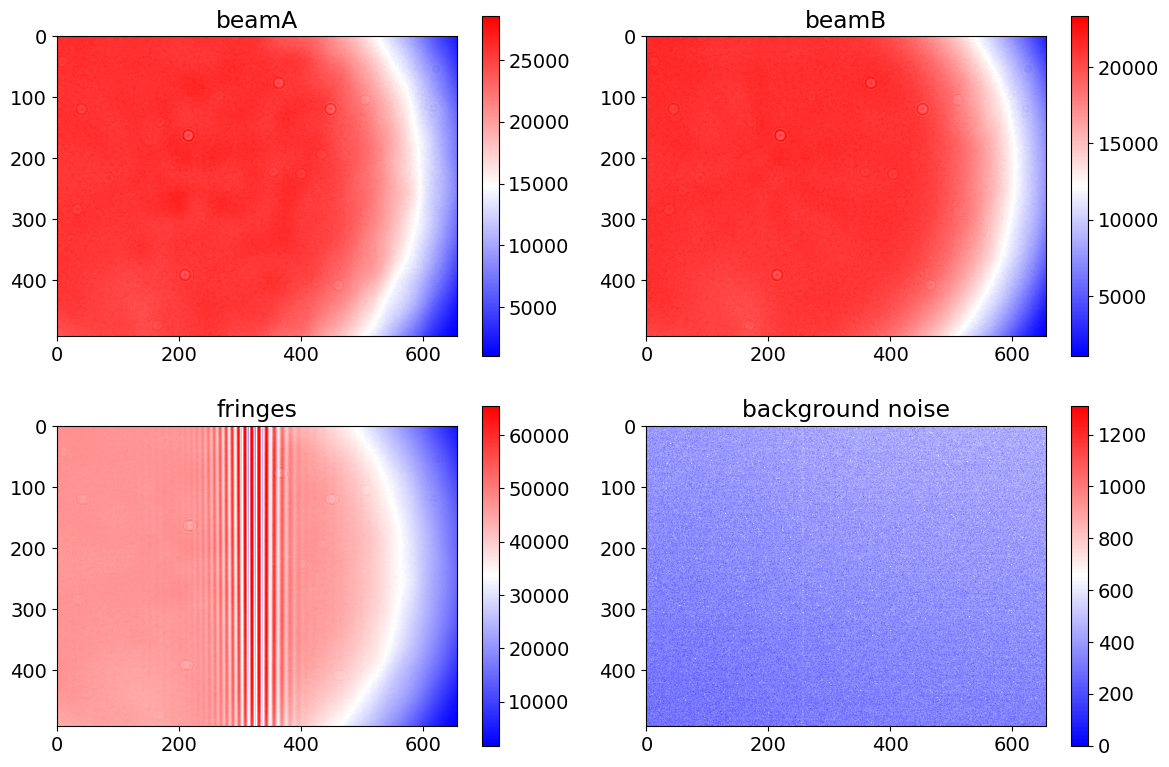

In [3]:
fringes, beamA, beamB, background = import_standard_tif(source, run)

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

In [4]:
beamPost, nofringes = process_fringes(fringes, beamA, beamB, background)
average_signal = np.mean(beamPost[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)

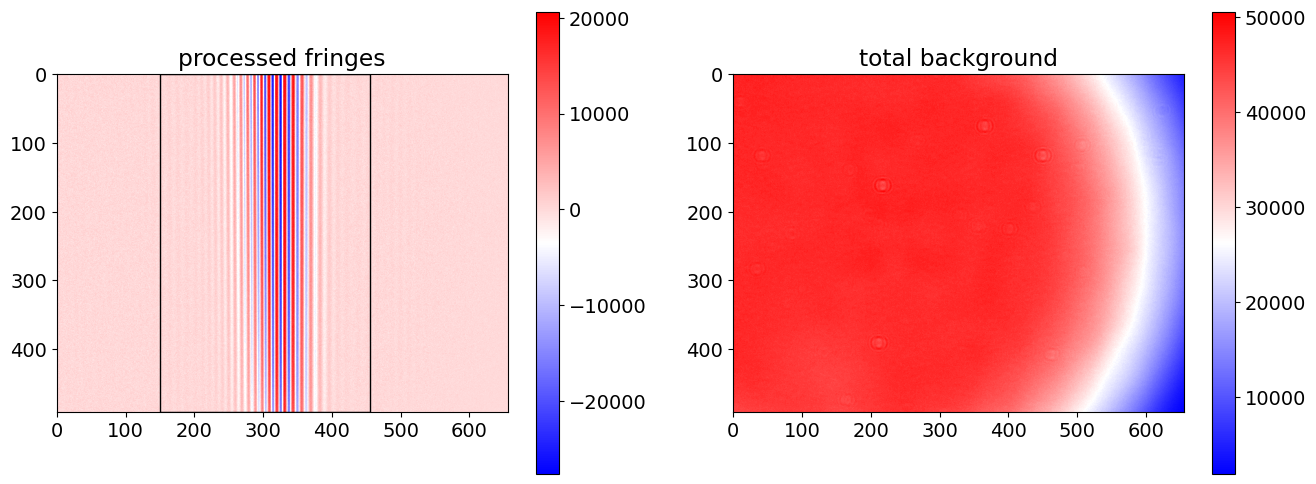

In [5]:
plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

# Create a Rectangle patch
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

plt.subplot(1,2,2)
im=plt.imshow(nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

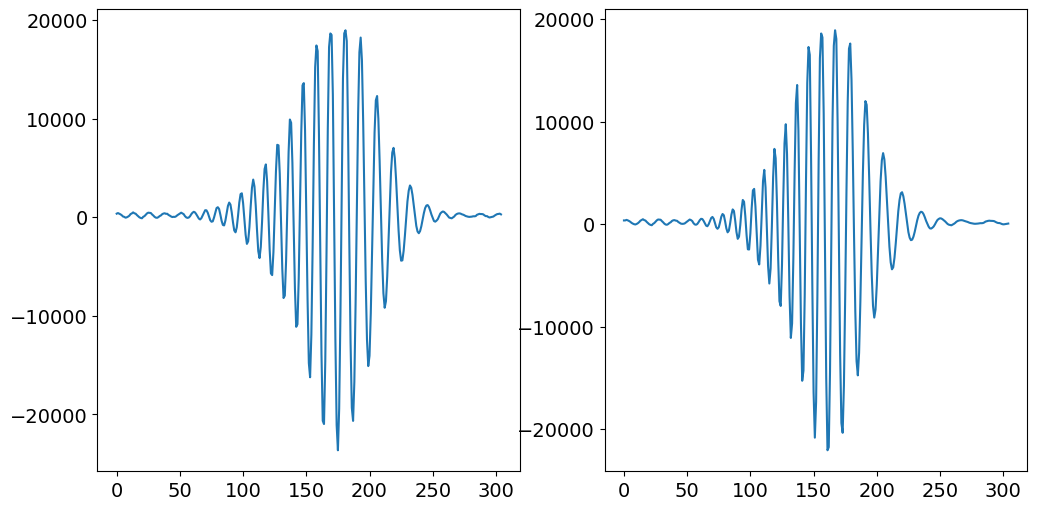

In [6]:
if anti_chirping == True:
    average_signal2 ,_,_, chirping_indexes = regularspacing(average_signal)

    plt.figure(figsize = (12,6))

    plt.subplot(1, 2, 1)
    plt.plot(average_signal)

    plt.subplot(1, 2, 2)
    plt.plot(average_signal2)

    plt.show()

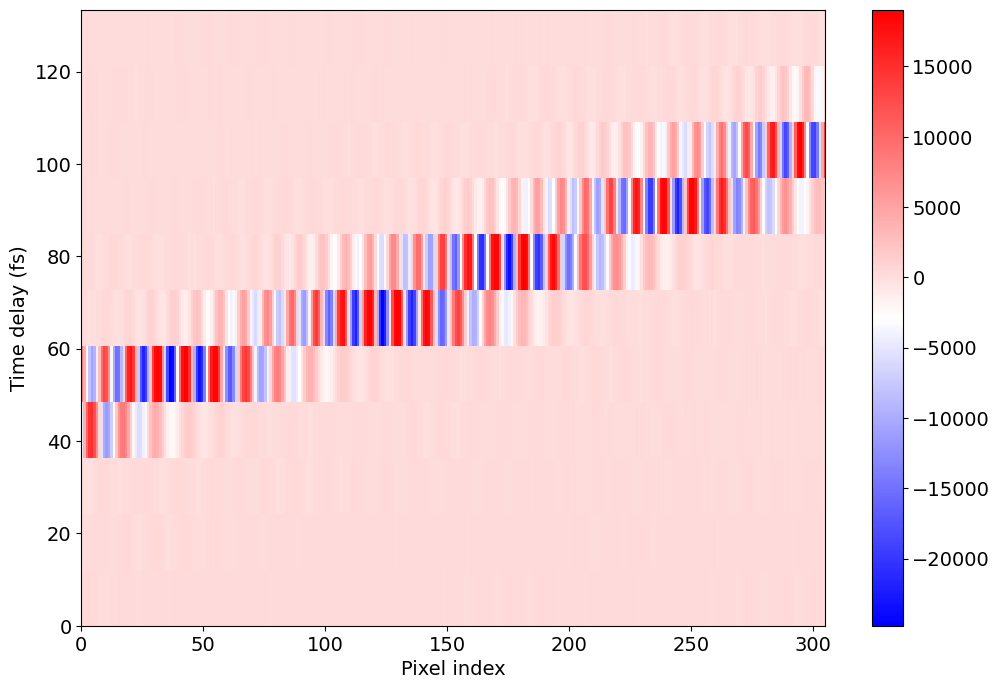

In [7]:
if angle_calculation_method == "delay":
    file_names, file_numbers = find_angle_files(source, run)
    angles = combine_angle_arrays(file_names)
    angles, _ = process_fringes(angles, beamA, beamB, background)
    angle_averages = np.mean(angles[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)
    

    delay_line_travel = np.arange(angle_averages.shape[1]) *delay_line_delta
    time_delay = delay_line_travel *2 /c
    time_delay *= 1e9 #convert from us to fs

    plt.figure(figsize = (12,8))

    ax = plt.subplot(1,1,1)
    im=plt.imshow(np.transpose(angle_averages), 
                cmap='bwr', 
                aspect = "auto", 
                interpolation = "none", #"none" and "nearest" are the only physical ones
                origin = "lower", 
                extent=[0,angle_averages.shape[0],0,time_delay[-1]])
    plt.colorbar(im)
    plt.xlabel("Pixel index")
    plt.ylabel("Time delay (fs)")

    plt.show()

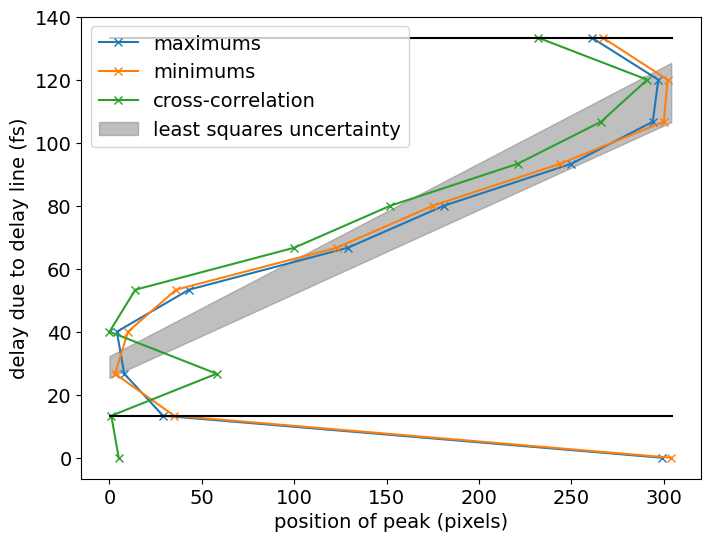

In [8]:
if angle_calculation_method == "delay":
        delay_line_bounds = [1,-1] #As the fringes move outside of the ROI, the peak position becomes inaccurate.

        maximums = np.argmax(angle_averages, axis = 0)
        minimums = np.argmin(angle_averages, axis = 0)
        cross_corr = apply_cross_corrlations(angle_averages, average_signal)
        # elin uses scipy.signal.find_peaks. IDK which meathod is better

        all_peak_estimates = np.concatenate((maximums[delay_line_bounds[0]:delay_line_bounds[1]], minimums[delay_line_bounds[0]:delay_line_bounds[1]], cross_corr[delay_line_bounds[0]:delay_line_bounds[1]]))
        time_delays = list(time_delay[delay_line_bounds[0]:delay_line_bounds[1]])*3

        popt, pcov = curve_fit(line, all_peak_estimates, time_delays)
        m = popt[0]
        k = popt[1]
        err_m = np.sqrt(pcov[0][0]) /m #make into percentage error
        err_k = np.sqrt(pcov[1][1]) /k


        fig, axs = plt.subplots(figsize = (8,6)) #subplots defults to only plotting 1 subplot.

        plt.plot(maximums,
                time_delay,
                label = "maximums",
                marker = "x")
        plt.plot(minimums,
                time_delay,
                label = "minimums",
                marker = "x")
        plt.plot(cross_corr,
                time_delay,
                label = "cross-correlation",
                marker = "x")
        x = np.arange(0, ROI[1][1] -ROI[1][0])
        axs.fill_between(x,
                        line(x, m*(1-err_m), k*(1-err_k)),
                        line(x, m*(1+err_m), k*(1+err_k)),
                        color = "gray",
                        alpha = 0.5,
                        label = "least squares uncertainty")

        plt.hlines([time_delay[delay_line_bounds[0]],time_delay[delay_line_bounds[1]]], 0, ROI[1][1] -ROI[1][0], color = "k")
        plt.ylabel('delay due to delay line (fs)')
        plt.xlabel('position of peak (pixels)')
        plt.legend()

        plt.show()

In [9]:
if angle_calculation_method == "delay":
    print("gradient = {0:.2e} +/- {1:.1e} ".format(m, err_m*m) + "fs/pixel")

    m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to um/us (= m/s)
    theta = np.arcsin(c *np.abs(m) /2 ) 
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    err_angle = angle_between_beams *np.abs(err_m) #relies on the small angle appoximation. This is an underestimate.
    print("angle between beams = {0:.3f} +/- {1:.3f}° or {2:.1f} +/- {3:.1f} arcminutes".format(angle_between_beams, 2*err_angle, 60*angle_between_beams, 60*2*err_angle))

gradient = 2.87e-01 +/- 2.0e-02 fs/pixel
angle between beams = 0.498 +/- 0.068° or 29.9 +/- 4.1 arcminutes


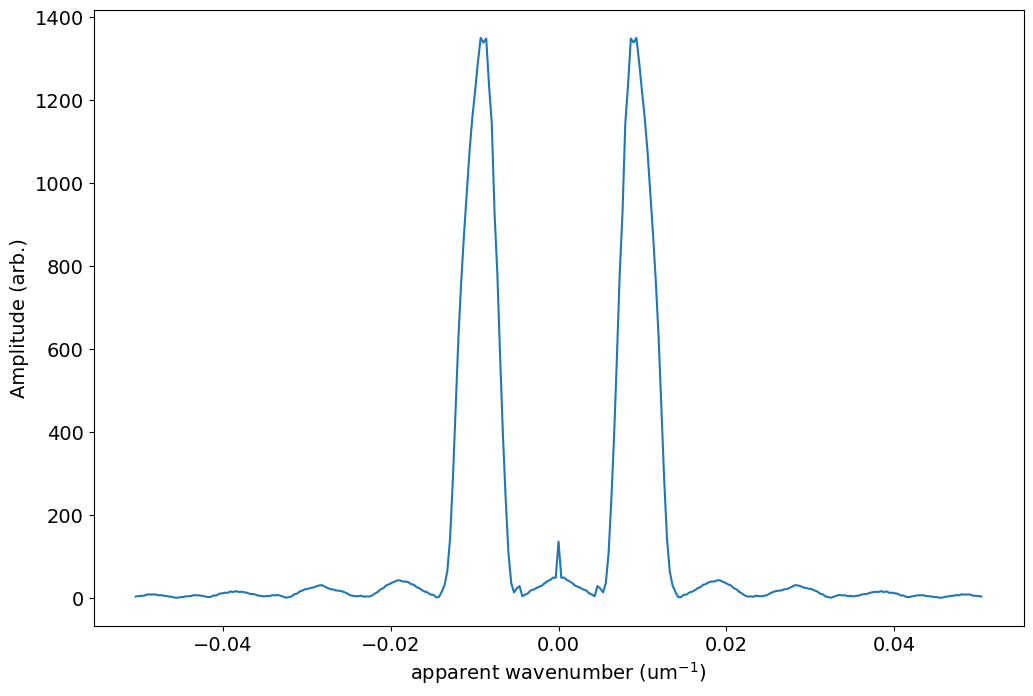

In [10]:
FT = np.fft.fft(average_signal2, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.fft.fftfreq(len(FT), pixel_pitch)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(np.fft.fftshift(freqs), #plt works best when the data set is in order
        np.fft.fftshift(abs(FT)))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_15420\1613298412.py:106: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs[:num_of_freqs]


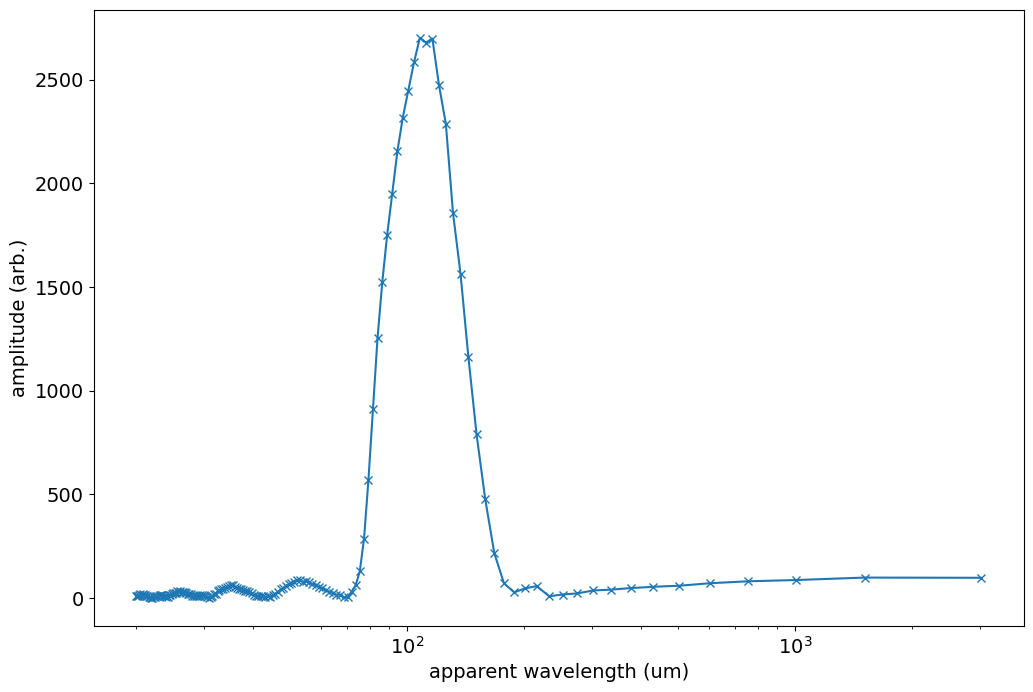

In [11]:
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])
amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude[:-1],
        marker = "x")
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

In [12]:
################COMPENSATE FOR ANGLE#################
if angle_calculation_method == "wavelength":
    theta = angle_between_beams/2 *np.pi/180
    theta = np.arcsin(calibration_wavelength /2 /wavelengths[np.argmax(amplitude)])
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    print("angle between beams = {0:.3f}° or {1:.1f} arcminutes".format(angle_between_beams, 60*angle_between_beams))

corrected_wavelengths = wavelengths *2*np.sin(theta)

###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise

camera = import_normalised_csv("mantra_spectrum.csv", 0)
camera[:,0] *= 1e-3 #convert to um
camera_function = interpolate.interp1d(camera[:,0], camera[:,1], fill_value= 0, bounds_error= False)

if source == "ir":
    source_data = import_normalised_csv("SLS201L_spectrum.csv", 1)
    source_data[:,0] *= 1e-3 #convert to um
    source_function = interpolate.interp1d(source_data[:,0], source_data[:,1], fill_value= 0, bounds_error= False) #Also try fill_value= np.nan

    mirror = import_normalised_csv("unprotected_gold_mirror_spectrum.csv", 1)
    mirror_function = interpolate.interp1d(mirror[:,0], mirror[:,1], fill_value= 0, bounds_error= False)

    def manufacturers_function(x):
        return mirror_function(x) *source_function(x) *camera_function(x)
    manufacturers = manufacturers_function(corrected_wavelengths[:-1] *1e3)
else:
    def manufacturers_function(x):
        return camera_function(x)
    manufacturers = manufacturers_function(corrected_wavelengths[np.argmax(amplitude)])

percentagediff = (manufacturers_function(corrected_wavelengths[:-1]) - amplitude[:-1]) /amplitude[:-1]
amplitude *= np.nanmin(percentagediff[percentagediff != -1]) +1 #re-scale to fit

normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1]) #factor in the camera sensitivity

C:\Users\syf83691\AppData\Local\Temp\ipykernel_15420\4111631666.py:37: RuntimeWarning: divide by zero encountered in divide
  normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1]) #factor in the camera sensitivity


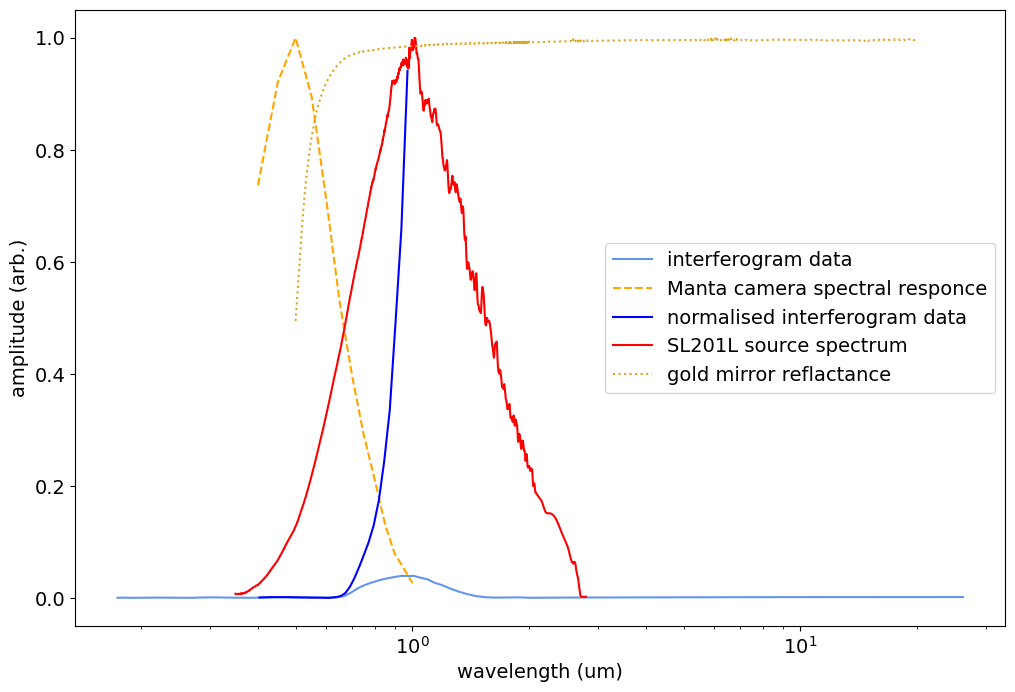

In [13]:
plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(corrected_wavelengths[:-1], #excule the infinate wavelength and convert to nm
        amplitude[:-1],
        label = "interferogram data",
        color = "cornflowerblue")
plt.plot(camera[:,0],
        camera[:,1],
        label = "Manta camera spectral responce",
        color = "orange",
        linestyle = "--")
plt.plot(corrected_wavelengths[:-1], #excule the infinate wavelength and convert to nm
        normalised_amplitude,
        label = "normalised interferogram data",
        color = "blue")
if source == "ir":
        plt.plot(source_data[:,0],
                source_data[:,1],
                label = "SL201L source spectrum",
                color = "red")
        plt.plot(mirror[:,0],
                mirror[:,1],
                label = "gold mirror reflactance",
                color = "goldenrod",
                linestyle = ":")
elif angle_calculation_method == "wavelength":
        try:
                plt.axvline(calibration_wavelength, color = source)
        except ValueError:
                plt.axvline(calibration_wavelength, color = "k")
plt.xlabel('wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.legend()
plt.show()

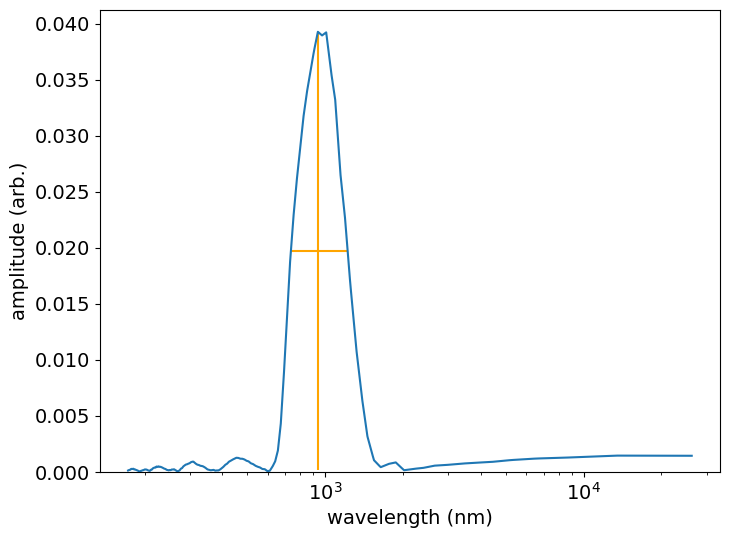

[936.73418331]
[657.99584741]


In [14]:
################FINDING PEAKS AND FWHM#####################

n = 100_000 #how many liniarlly spaced points to plot. It has to be liniar in order to be able to convert from indexes to um
relative_prominence = 5e-1 #this should be at least 1 / the S:N ratio.

spectrum_function = interpolate.interp1d(corrected_wavelengths[1:], amplitude[1:])
x = np.linspace(corrected_wavelengths[-1], corrected_wavelengths[1], n)
y = spectrum_function(x)

peaks, peak_properties = signal.find_peaks(y, prominence = relative_prominence*y.max()) #prominence = the smallest peak that can be considered a signal rather than noise. It would be nice to calculate this.
FWHM = signal.peak_widths(y, peaks, rel_height=0.5) #gives the FWHM in terms of indexes
FWHM = np.vstack(FWHM)

peaks = peaks * (corrected_wavelengths[1] - corrected_wavelengths[-1]) /n + corrected_wavelengths[-1] #convert to um
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1] * (corrected_wavelengths[1] - corrected_wavelengths[-1]) /n + corrected_wavelengths[-1] #convert to um.
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1]*1e3 #convert to nm. FWHM[np.arange(len(FWHM))!=1] will exclude index 1 (height of FWHM)

plt.figure(figsize = (8,6))
plt.subplot(1, 1, 1)

plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
#plt.xscale("log")
plt.hlines(*FWHM[1:,:], color = "orange")
plt.vlines(x= peaks*1e3,
           ymin= spectrum_function(peaks) - peak_properties["prominences"],
           ymax= spectrum_function(peaks), 
           color= "orange")
plt.plot(x *1e3,
        y)

#plt.xlim(3e2, 8e2)
plt.xscale("log")
plt.ylim(0)

plt.show()

print(peaks*1e3) # in nm
print(FWHM[0])